In [ ]:
import pickle
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Bidirectional, Dropout, LSTM
from tensorflow.keras import Model
from tensorflow.keras.backend import ctc_decode

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print('All Devices: ', tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.138.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.138.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All Devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with open('./drive/MyDrive/imgtensor_sh.pkl','rb') as arrbee:
    img_tensor_sh = pickle.load(arrbee)

In [ ]:
with open('./labeltensor_shpad.pkl','rb') as ry:
    lab_tensor_sh = pickle.load(ry)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
charlist = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz .,-+1234567890'

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:

input_img = Input(shape=(480,679,1),name='image',dtype="float32")
#labels = Input(shape=None,name='label',dtype="int32") #we're using ragged tensors, so no set shape

x = Conv2D(32,(3,3),activation='relu',name='Conv1')(input_img)
x = MaxPooling2D((2,2), name = "pool1")(x)

x = Conv2D(64,(3,3),activation='relu',name='Conv2')(x)
x = MaxPooling2D((2,2), name = "pool2")(x)

shape = ((480//4)-2,((679//4)-1)*64)

x = Reshape(target_shape=shape, name = 'reshape')(x)
x = Dense(64, activation='relu', name ='dense1')(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(128,return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64,return_sequences=True,dropout=0.25))(x)

output = Dense(len(charlist)+2,activation='softmax',name='dense2')(x)
model = Model(input_img,output,name='basic-OCR')
model.compile(optimizer='adam',loss=CTCLoss)


In [ ]:
model.summary()

Model: "basic-OCR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 480, 679, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 478, 677, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 239, 338, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 237, 336, 64)      18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 118, 168, 64)      0         
                                                                 
 reshape (Reshape)           (None, 118, 10752)        0         
                                                                 
 dense1 (Dense)              (None, 118, 64)           68

In [ ]:
eps = 100
history = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2,epochs=eps)

Epoch 1/100
36/36 [==============================] - 41s 377ms/step - loss: 87.9713 - val_loss: 56.6251
Epoch 2/100
36/36 [==============================] - 11s 305ms/step - loss: 49.7374 - val_loss: 54.1567
Epoch 3/100
36/36 [==============================] - 11s 310ms/step - loss: 43.0112 - val_loss: 50.9455
Epoch 4/100
36/36 [==============================] - 11s 308ms/step - loss: 40.4994 - val_loss: 42.3830
Epoch 5/100
36/36 [==============================] - 11s 309ms/step - loss: 38.9408 - val_loss: 40.5787
Epoch 6/100
36/36 [==============================] - 11s 311ms/step - loss: 37.7682 - val_loss: 38.9132
Epoch 7/100
36/36 [==============================] - 11s 309ms/step - loss: 36.8069 - val_loss: 37.9136
Epoch 8/100
36/36 [==============================] - 11s 311ms/step - loss: 34.8083 - val_loss: 37.7145
Epoch 9/100
36/36 [==============================] - 11s 312ms/step - loss: 34.0323 - val_loss: 36.3600
Epoch 10/100
36/36 [==============================] - 11s 310ms/

In [ ]:
prediction_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)

In [ ]:
preds = prediction_model.predict(img_tensor_sh[10:20])

In [ ]:
tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[1400:1405]])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([10,  6,  1,  7,  1])>

In [ ]:
pred_texts = ctc_decode(preds,
                        tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[10:20]]),
                       greedy=True)

In [ ]:
pred_texts[0][0][1]

<tf.Tensor: shape=(118,), dtype=int64, numpy=
array([ 1, 38, 27, 28, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])>

In [ ]:
[''.join([charlist[l-1] for l in pred.numpy() if l>0]) for pred in pred_texts[0][0]]

['Ca', 'Alab', 'W', 'Hea', 'Mo', 'VT', 'M', 'H', 'No o', 'Lo']

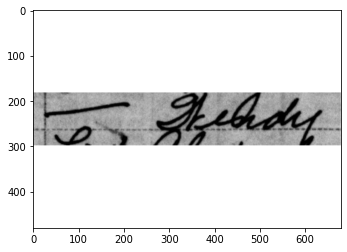

In [ ]:
plt.imshow(img_tensor_sh[20],cmap='gray')

In [ ]:
lab_tensor_sh[20]

<tf.Tensor: shape=(37,), dtype=int32, numpy=
array([56, 56, 56, 53, 23, 31, 40, 30, 51,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)>

In [ ]:
model.save('./first_model_diff')

INFO:tensorflow:Assets written to: ./first_model_diff/assets


INFO:tensorflow:Assets written to: ./first_model_diff/assets


In [ ]:
!zip -r /content/file.zip ./first_model/

  adding: first_model/ (stored 0%)
  adding: first_model/saved_model.pb (deflated 90%)
  adding: first_model/assets/ (stored 0%)
  adding: first_model/variables/ (stored 0%)
  adding: first_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: first_model/variables/variables.index (deflated 70%)


In [ ]:
!zip -r /content/fm.zip ./first_model_diff/

  adding: first_model_diff/ (stored 0%)
  adding: first_model_diff/saved_model.pb (deflated 90%)
  adding: first_model_diff/keras_metadata.pb (deflated 93%)
  adding: first_model_diff/assets/ (stored 0%)
  adding: first_model_diff/variables/ (stored 0%)
  adding: first_model_diff/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: first_model_diff/variables/variables.index (deflated 70%)


(-10.0, 0.0)

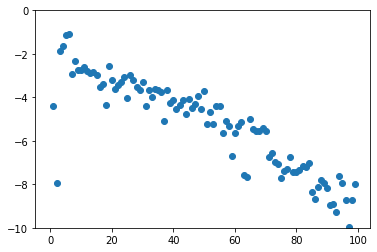

In [ ]:
plt.scatter(range(100),(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
plt.ylim([-10,0]) #val_loss not keeping up with first 100 rounds- but why not another 100?


In [ ]:
hist2 = model.fit(img_tensor_sh,lab_tensor_sh,validation_split=0.2,epochs=eps)

Epoch 1/100
36/36 [==============================] - 11s 314ms/step - loss: 19.0362 - val_loss: 27.9032
Epoch 2/100
36/36 [==============================] - 11s 306ms/step - loss: 18.8653 - val_loss: 28.4656
Epoch 3/100
36/36 [==============================] - 11s 304ms/step - loss: 19.1138 - val_loss: 29.1057
Epoch 4/100
36/36 [==============================] - 11s 306ms/step - loss: 18.8707 - val_loss: 29.3085
Epoch 5/100
36/36 [==============================] - 11s 306ms/step - loss: 19.1472 - val_loss: 29.4338
Epoch 6/100
36/36 [==============================] - 11s 310ms/step - loss: 19.2555 - val_loss: 28.1522
Epoch 7/100
36/36 [==============================] - 11s 304ms/step - loss: 19.5287 - val_loss: 27.8573
Epoch 8/100
36/36 [==============================] - 11s 303ms/step - loss: 18.7743 - val_loss: 27.4502
Epoch 9/100
36/36 [==============================] - 11s 302ms/step - loss: 18.5234 - val_loss: 27.9447
Epoch 10/100
36/36 [==============================] - 11s 305ms/

In [ ]:
prediction_model = Model(model.get_layer(name='image').input, model.get_layer(name='dense2').output)

In [ ]:
preds = prediction_model.predict(img_tensor_sh[1200:1220])

In [ ]:
pred_texts = ctc_decode(preds,
                        tf.convert_to_tensor([len([l for l in lab if l>0]) for lab in lab_tensor_sh[1200:1220]]),
                       greedy=True)

In [ ]:
[''.join([charlist[l-1] for l in pred.numpy() if l>-1]) for pred in pred_texts[0][0]]

['Ne',
 '---, Ja',
 'F',
 'U',
 'No ',
 '46',
 'Co Wa',
 'No one t ho',
 'F',
 'Co Mo',
 '30',
 'ne',
 'Ro ',
 '23',
 '--- a',
 'No',
 'N9',
 '23',
 'Ne',
 'No one ho']

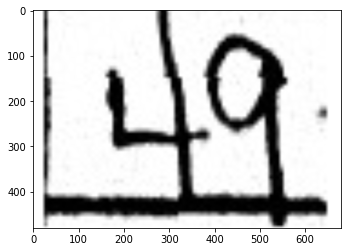

In [ ]:
plt.imshow(img_tensor_sh[1216],cmap='gray')

In [ ]:
lab_tensor_sh[1207]

<tf.Tensor: shape=(37,), dtype=int32, numpy=
array([ 8, 47, 28, 28, 27, 44, 30, 53,  3, 34, 27, 44, 38, 31, 45,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)>

In [ ]:
model.save('./first_model_200')

INFO:tensorflow:Assets written to: ./first_model_200/assets


INFO:tensorflow:Assets written to: ./first_model_200/assets


In [ ]:
!zip -r /content/fm2.zip ./first_model_200/

  adding: first_model_200/ (stored 0%)
  adding: first_model_200/saved_model.pb (deflated 90%)
  adding: first_model_200/keras_metadata.pb (deflated 93%)
  adding: first_model_200/assets/ (stored 0%)
  adding: first_model_200/variables/ (stored 0%)
  adding: first_model_200/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: first_model_200/variables/variables.index (deflated 70%)
